In [1]:
import os  # for directory manipulation
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
import copy

#os.chdir("C:/Users/mephamk/Google Drive/Course Docs/PhD/ETH - Social Networks through Time/BARJ/")
doc_features = pd.read_pickle("doc_features.pkl")

In [2]:
# Creating the object storing the frequencies of each trigram found across all documents
# Note that doc_features already contains a column of all trigrams (from problem set 1)
# This is also part of problem 2
from collections import Counter

docfreqs = Counter()
termcounts = Counter()
total_length = 0
for i, row in doc_features.iterrows():
    termcounts.update(row["trigrams"])  # how many times each trigram appears across all documents
    total_length += row['n_trigrams']  # number of (noun-ending) trigrams per doc, logical value to normalize on
    grams_unique = set(row['trigrams'])  # takes out duplicates from each separate doc's trigrams
    docfreqs.update(grams_unique)  # in how many documents each trigram appears

# taking the threshold of min 2 documents to reduce bias of tf-idf scores
filter_docfreqs = dict((k, v) for k, v in docfreqs.items() if v >= 3)

# computing tf-idf
idf_scores = {}
num_docs = len(doc_features)
for g, docfreq in filter_docfreqs.items():
    idf_scores[g] = np.log( num_docs / docfreq )

# selecting the 1000 cases with highest tf_idf
tf_idf = {}
for w in filter_docfreqs:
    tf_idf[w] = (termcounts[w] / total_length) * idf_scores[w]
np.mean(list(tf_idf.values()))
filter_tf_idf = dict(Counter(tf_idf).most_common(1000))

# examples of the trigrams, note that these are quite common phrases
sorted(filter_tf_idf.keys())[100:105]

# here I find all 1000 selected features per document and count them
feature_list = []
for i, row in doc_features.iterrows():

    freq_counter = Counter(row["trigrams"])
    selected_features = []
    # loop through the counter and find all of our preselected features' counts, add to a list
    for ngram in sorted(filter_tf_idf.keys()):
        selected_features.append(freq_counter[ngram])
    feature_list.append(selected_features)

# finally, create a dataframe of the features
features = sorted(filter_tf_idf.keys())
df_features = pd.DataFrame(feature_list, columns=features)


In [3]:
# Problem 1: Take your best hyperparameters for the logistic regression model from Problem Set 1 (or find them with a 
# new model). Use cross_val_predict() to form model predictions of reversed for each observation. Construct a confusion
# matrix for the predictions. Report the precision_recall_curve() and roc_curve(). Make a calibration plot (as in 
# Bansak et al 2018, appendix page 24).

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# first, preparing data

# making a df of features selected on value not missing of outcome
valid_cases = doc_features.case_reversed.notnull()
df_features_reverse = df_features.loc[valid_cases, :]
# this function standardizes the data by column. Mean is not subtracted to preserve sparsity.
df_full = preprocessing.scale(df_features_reverse, axis=0, with_mean=False, with_std=True, copy=True)

# sampling every 3rd case
test_sample = np.arange(0, len(df_full), 3)

# creating the training sample by taking all cases not in the test sample
train_sample = np.arange(0, len(df_full))
train_sample = [i for i in train_sample if i not in test_sample]

df_test = df_full[test_sample,:]
df_train = df_full[train_sample,:]

# attaching the case outcomes
reverse = doc_features.loc[valid_cases, "case_reversed"].values
reverse_test = reverse[test_sample]
reverse_train = reverse[train_sample]



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  app.launch_new_instance()


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change 

Confusion matrix of decision reversals: upper left is true negative, upper right is false positive
[[ 53 123]
 [ 60 233]]


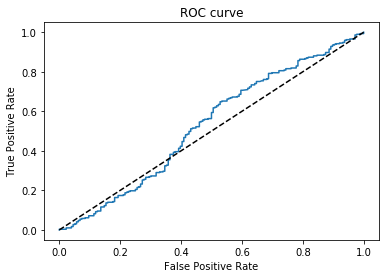

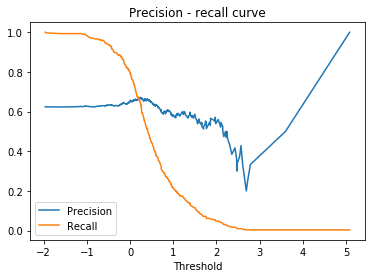

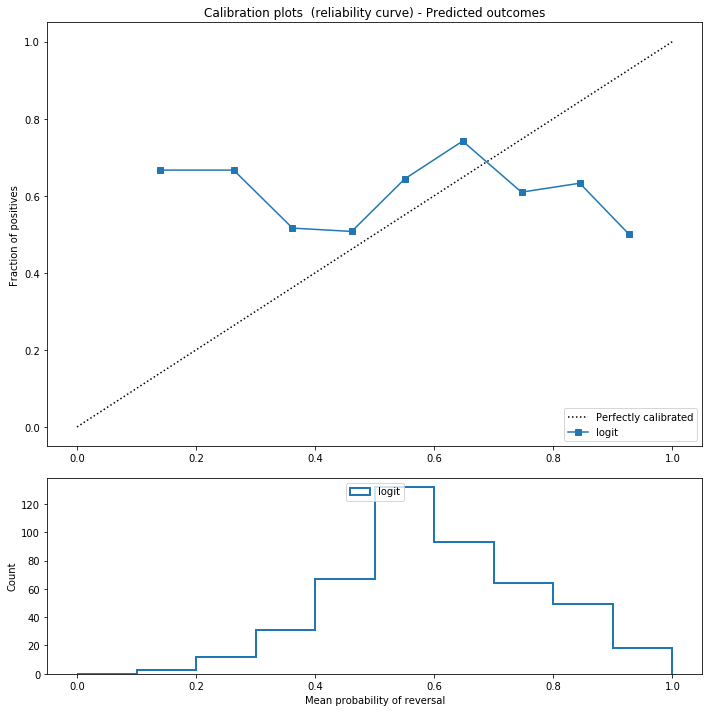

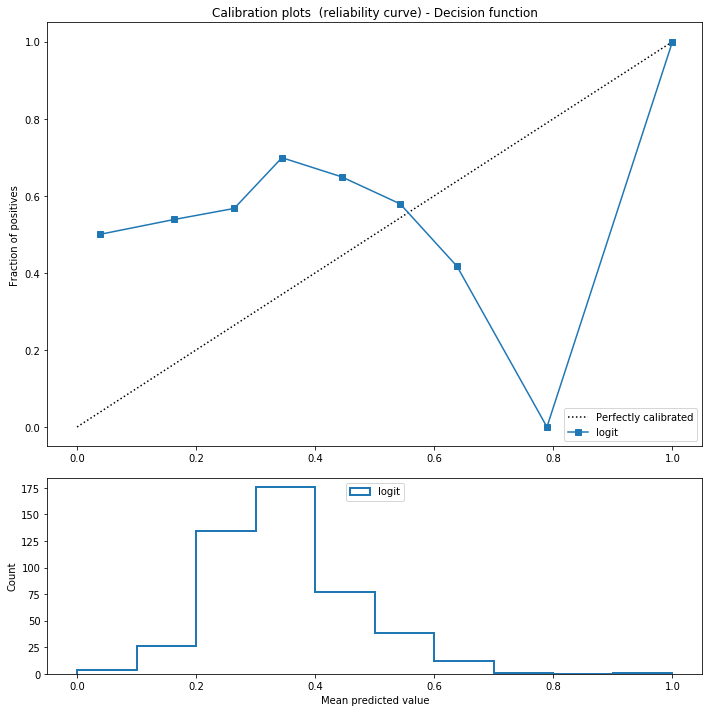

In [4]:
# In this box I generate the predictions/show the plots requested
import sklearn.model_selection as ms
from sklearn import calibration
# loading optimized model
with open('saved_classifier.pkl', 'rb') as f:
    optim_model = pickle.load(f)

# predictions made by the model on full dataset
reverse_pred = ms.cross_val_predict(optim_model.best_estimator_, df_full, reverse,method='predict')

# predicted probabilities in the full dataset
reverse_prob = ms.cross_val_predict(optim_model.best_estimator_, df_full, reverse,method='predict_proba')
prob_pos = reverse_prob[:,1]

# decision function values in the full dataset
reverse_decfunc = ms.cross_val_predict(optim_model.best_estimator_, df_full, reverse,method='decision_function')
prob_pos_decfunc = (reverse_decfunc - reverse_decfunc.min()) / (reverse_decfunc.max() - reverse_decfunc.min())

# showing confusion matrix
# upper left is true negative, upper right is false positive
print("Confusion matrix of decision reversals: upper left is true negative, upper right is false positive")
print(metrics.confusion_matrix(reverse, reverse_pred))

# printing ROC curve

fpr, tpr, thresholds = metrics.roc_curve(reverse, reverse_decfunc)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

# printing precision recall curve
precisions, recalls, thresholds = metrics.precision_recall_curve(reverse, reverse_decfunc)
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel('Threshold')
plt.legend()
plt.title('Precision - recall curve')
plt.show()

# calibration curve; code modified from:
# https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html

# configure plot sizes etc
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# generate curve
fraction_of_positives, mean_predicted_value = calibration.calibration_curve(reverse, reverse_prob[:,1],
                                                                            n_bins=10)

# plot
ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % ("logit", ))

ax2.hist(prob_pos, range=(0, 1), bins=10, label="logit", histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve) - Predicted outcomes')

ax2.set_xlabel("Mean probability of reversal")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()


# and using the decision function
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# generate curve
fraction_of_positives, mean_predicted_value = calibration.calibration_curve(reverse, reverse_decfunc,
                                                                            n_bins=10, normalize = True)

# plot
ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % ("logit", ))

ax2.hist(prob_pos_decfunc, range=(0, 1), bins=10, label="logit", histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve) - Decision function')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Performance is generally awful. Given that there are only 3 bands of points, I suspect there's only 2 nonzero coefficients left by the net


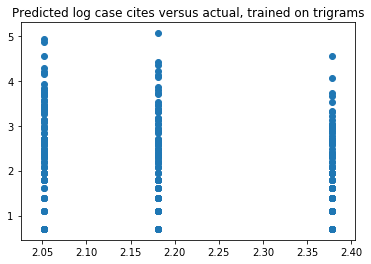

In [5]:
# Problem 2: Scale your n-gram frequencies while maintaining sparsity, as discussed in class. Train an elastic net model
#    to predict log citations to a case (log_cites). Run cross_val_predict() to form model predictions and report a
#    scatter plot of true and predicted values.

from sklearn.linear_model import ElasticNet

# First, preparing data again.

# Selecting on non-missing on outcome
valid_cases = doc_features.log_cites.notnull()
df_features_cites = df_features.loc[valid_cases, :]
# this function standardizes the data by column. Mean is not subtracted to preserve sparsity.
df_full = preprocessing.scale(df_features_cites, axis=0, with_mean=False, with_std=True, copy=True)

# sampling every 3rd case
test_sample = np.arange(0, len(df_full), 3)

# creating the training sample by taking all cases not in the test sample
train_sample = np.arange(0, len(df_full))
train_sample = [i for i in train_sample if i not in test_sample]

df_test = df_full[test_sample,:]
df_train = df_full[train_sample,:]

# creating the true values for test and training
cites = doc_features.loc[valid_cases, "log_cites"].values
cites_test = cites[test_sample]
cites_train = cites[train_sample]

# training
cites_pred = ms.cross_val_predict(ElasticNet(), df_full, cites)

# plotting
plt.scatter(cites_pred, cites)
plt.title("Predicted log case cites versus actual, trained on trigrams")
print("Performance is generally awful. Given that there are only 3 bands of points, I suspect there's only 2 nonzero coefficients left by the net")


In [6]:
# Problem 3. Use the judge identifiers (judge_id) to produce the average citations to cases for each judge. Then estimate
# a two-stage least-squares model with Z as average citations of the judge, X as citations to the case, and Y as
# whether the case was reversed. Include year fixed effects. Report estimates for coefficient and standard error on X.

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm # used for estimating the fixed effects model

# load the metadata
case_metadata = pd.read_csv(os.path.join(os.getcwd(), "case_metadata.csv"))

# selecting on judge being known
valid_judges = case_metadata.judge_id.notnull()
# not sure if reindexing below will mess up the original object so I take a copy (selecting on valid obs)
features_judge = case_metadata.loc[valid_judges, :].copy()

# creating the judge mean variable
avg_judge_cites = features_judge.groupby("judge_id")["log_cites"].mean()
features_judge = features_judge.set_index("judge_id")  # make the same index here
features_judge['avg_judge_cites'] = avg_judge_cites
features_judge = features_judge.reset_index()  # reset the index

# select on non-na on all relevant vars (avg cites by judge, case cites, year, reversal)
doc_regr_features = features_judge[["avg_judge_cites", "log_cites", "year", "case_reversed"]]
doc_regr_features = doc_regr_features.dropna()

# estimate first stage by regression X on Z, save predictions X'


def gen_iv(Z, X):
    a = LinearRegression().fit(X=Z, y=X)  # fitting model where our desired X is predicted by Z
    de_endog = LinearRegression.predict(a, Z)  # extracting the predictions
    return de_endog


av_cites = doc_regr_features['avg_judge_cites'].values.reshape(-1,1)
log_cites = doc_regr_features['log_cites'].values.reshape(-1,1)

# creating the deendogenized var
deendog_cites = gen_iv(av_cites, log_cites)
doc_regr_features.loc[:, "deendog_cites"] = deendog_cites

# get dummies for year to use as fixed effects
year_dummies = pd.get_dummies(doc_regr_features["year"])
predictors = pd.concat([doc_regr_features[["deendog_cites"]], year_dummies], axis=1)

# regress reversal on de-endogenized var and year dummies
model = sm.Logit(doc_regr_features["case_reversed"], predictors).fit()
print("parameter estimate for de-endogenized citations predicting reversal is:", model.params[0])
print("se for parameter estimate is:", model.bse[0])


Optimization terminated successfully.
         Current function value: 0.635439
         Iterations 6
parameter estimate for de-endogenized citations predicting reversal is: -0.5088898436016766
se for parameter estimate is: 0.08258158304719868


Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
312/312 [==============================] - ETA: 2s - loss: 1.0053 - acc: 0.500 - 0s 901us/step - loss: 0.9177 - acc: 0.4615
results of Keras logit for f1, accuracy, and auc, plus roc and precision /recall plots:


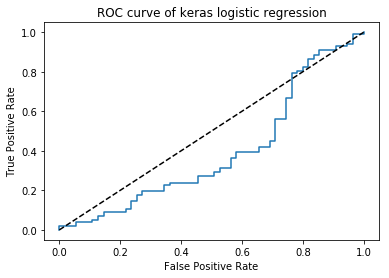

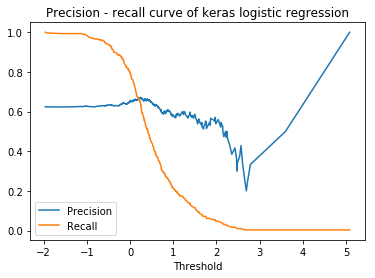

[0.4666666666666667, 0.3885350318471338, 0.39465240641711224]
results of sklearn optimized logit for f1, accuracy, and auc, plus roc and precision /recall plots:


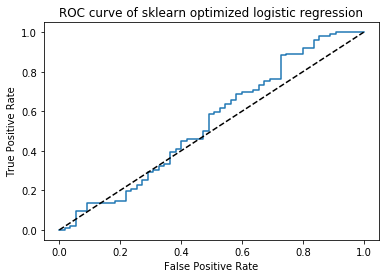

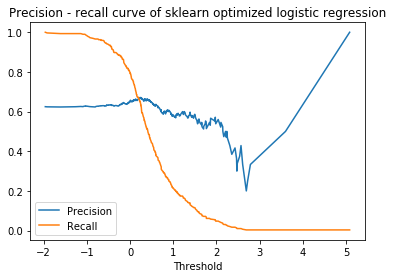

[0.6981132075471698, 0.5923566878980892, 0.5399286987522282]
Our first regression is (much) better - presumably because it is well-optimized


In [7]:
# Problem 5. Replicate your sklearn logistic regression model (no hidden layers, L2 regularization, and softmax output 
# layer in Keras or some other deep learning library. Compare performance. Now add two hidden layers, dropout, and batch
# normalization. Compare performance.
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
from keras.utils import to_categorical

# reprocessing data
valid_cases = doc_features.case_reversed.notnull()
df_features_reverse = df_features.loc[valid_cases, :]
# standardizing data by column. Mean is not subtracted to preserve sparsity.
df_full = preprocessing.scale(df_features_reverse, axis=0, with_mean=False, with_std=True, copy=True)

# sampling every ith case for testing
test_sample = np.arange(0, len(df_full), 3)

# creating the training sample by taking all cases not in the test sample
train_sample = np.arange(0, len(df_full))
train_sample = [i for i in train_sample if i not in test_sample]

df_test = df_full[test_sample, :]
df_train = df_full[train_sample, :]

# reformatting the observed values
y_true = doc_features.loc[valid_cases, "case_reversed"].values.reshape(-1,1)
y_test = y_true[test_sample, :]
y_train = y_true[train_sample, :]


def create_baseline():
    # create model   # as I understand it, this just says that the layers would be sequential
    model = Sequential()
    # I add one layer with input dims equal to the number of trigrams (i.e. connect all inputs to one output)
    # and l2 regularization. 
    model.add(Dense(1, input_dim=1000,
                    kernel_initializer='normal',
                    kernel_regularizer=l2(0.01),
                    activation='sigmoid'))
    # Compile model, I use categorical crossentropy classification - I do not know how to set the same as in sklearn
    # also, using binary_crossentropy (the default) always produces 1s for softmax (I don't understand why)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_baseline()
# fitting keras model, getting a decision score (to be honest, not sure how this relates to scikits decision function)
model.fit(df_train, y_train)
yhat_k_lr_test_decfunc = model.predict(df_test)

# since we used dummies, predictions are a row that sums to 1 for each doc, so I clear part of it
#yhat_k_lr_test_decfunc = yhat_k_lr_test_decfunc[:,1]
# then create predictions (rounding, i.e. a .5 threshold)
yhat_k_lr_test_pred = np.round(yhat_k_lr_test_decfunc, 0)

# using optimized sk model to generate decision scores
yhat_sk_lr_test_decfunc = optim_model.decision_function(df_test)
# using optimized sk model to predict class
yhat_sk_lr_test_pred = optim_model.predict(df_test)

# generating comparisons


def comparison(y_true, y_pred, y_decfunc, title):
    f1 = metrics.f1_score(y_pred, y_true)
    accuracy = metrics.accuracy_score(y_pred, y_true, normalize=True)
    auc = metrics.roc_auc_score(y_true, y_decfunc)
    res = [f1, accuracy, auc]
    # printing ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_decfunc)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC curve of "+ title)
    plt.show()

    # printing precision recall curve
    precisions, recalls, thresholds = metrics.precision_recall_curve(reverse, reverse_decfunc)
    plt.plot(thresholds, precisions[:-1], label="Precision")
    plt.plot(thresholds, recalls[:-1], label="Recall")
    plt.xlabel('Threshold')
    plt.legend()
    plt.title("Precision - recall curve of "+ title)
    plt.show()
    
    return res


print("results of Keras logit for f1, accuracy, and auc, plus roc and precision /recall plots:")
print(comparison(y_test, yhat_k_lr_test_pred, yhat_k_lr_test_decfunc, "keras logistic regression"))
print("results of sklearn optimized logit for f1, accuracy, and auc, plus roc and precision /recall plots:")
print(comparison(y_test, yhat_sk_lr_test_pred, yhat_sk_lr_test_decfunc, "sklearn optimized logistic regression"))
print("Our first regression is (much) better - presumably because it is well-optimized")


Epoch 1/1
312/312 [==============================] - ETA: 12s - loss: 1.1675 - acc: 0.43 - ETA: 5s - loss: 1.0395 - acc: 0.4531 - ETA: 3s - loss: 0.9554 - acc: 0.510 - ETA: 2s - loss: 1.0082 - acc: 0.500 - ETA: 1s - loss: 1.0157 - acc: 0.481 - ETA: 1s - loss: 1.0637 - acc: 0.474 - ETA: 0s - loss: 1.1414 - acc: 0.459 - ETA: 0s - loss: 1.1210 - acc: 0.468 - ETA: 0s - loss: 1.1077 - acc: 0.472 - 2s 6ms/step - loss: 1.1058 - acc: 0.4776
results of sklearn optimized logit for f1, accuracy, and auc, plus roc and precision /recall plots:


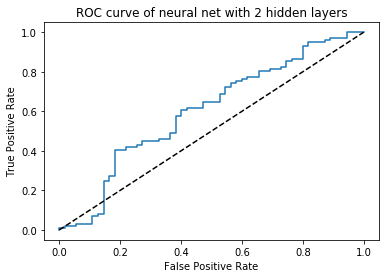

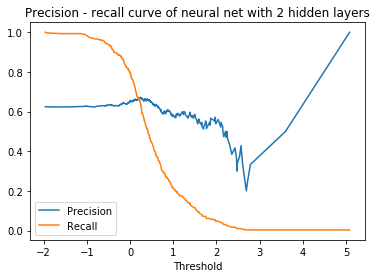

[0.6631016042780749, 0.5987261146496815, 0.6026737967914438]
Performance is often better here across all metrics!


In [10]:
# now training the 2-hidden layers neural net with batch normalization and dropout

from keras.layers import Dropout
from keras.layers import BatchNormalization

def create_deepnet():
    # create model
    model = Sequential()
    # I add three (two hidden) layers with input dims equal to the number of trigrams. Arbitrary number of
    # nodes in the hidden layers, and using relu to activate them as per lecture. I remove l2 regularization.
    # it seems if I do dropout before normalization performance gets worse as the model estimates
    model.add(Dense(1000, input_dim=1000, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))  # I use a 30% dropout; layers are large and I don't have a good idea of a good val
    # except that it should be between 20 and 50%
    model.add(Dense(1000, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))

    # compile model with same loss/optimization as before
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


model_nn = create_deepnet()

# fitting keras model, getting a decision score (to be honest, not sure how this relates to scikits decision function)
model_nn.fit(df_train, y_train)

yhat_k_nn_test_decfunc = model_nn.predict(df_test)

# then create predictions (rounding, i.e. a .5 threshold)
yhat_k_nn_test_pred = np.round(yhat_k_nn_test_decfunc, 0)

# since we used dummies, predictions are a row that sums to 1 for each doc, so I clear part of it
yhat_k_nn_test_decfunc = yhat_k_nn_test_decfunc

print("results of sklearn optimized logit for f1, accuracy, and auc, plus roc and precision /recall plots:")
print(comparison(y_test, yhat_k_nn_test_pred, yhat_k_nn_test_decfunc, "neural net with 2 hidden layers"))

print("Performance is often better here across all metrics!")
